In [2]:
import urllib.request
import urllib.parse
import json
import html
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from concurrent.futures import ThreadPoolExecutor # 병렬 처리 관련 라이브러리리

### 일부 데이터가 No contents로 본문 내용이 누락되고, 데이터가 700~800까지만 생성되는 문제 발생

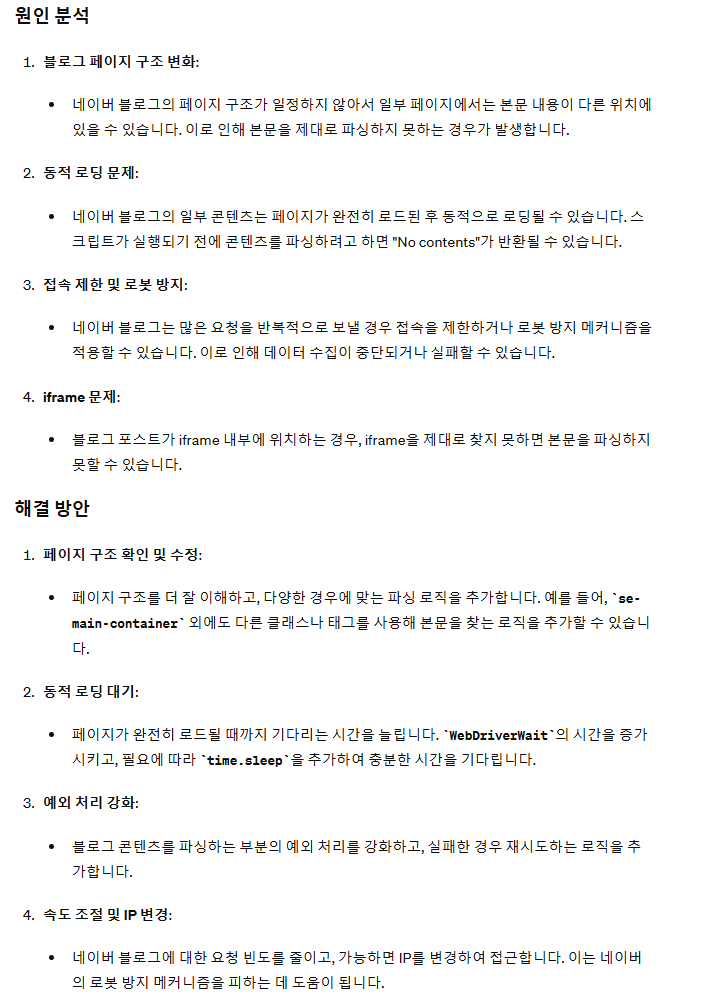

### GPT로 일부 코드 수정

In [4]:

# 네이버 API 설정
client_id = 'IoXYFGy9vINtT325U_Iw'
client_secret = 't8oDvUFyfr'
base_url = 'https://openapi.naver.com/v1/search/blog.json'

# 2번에 나눠서 수집
 # keywords = ['국민은행', '우리은행', 'SC제일은행', '하나은행', '신한은행','한국은행',
 #             '케이뱅크','토스뱅크','농협은행','수협은행','대구은행','부산은행','경남은행']
keywords = ['한국산업은행', '중소기업은행', '한국수출입은행','한국씨티은행','카카오뱅크','IBK저축은행','웰컴저축은행' ]
n_display = 30  # 한 번에 가져오는 결과 수를 30개로 설정
sort = 'sim'

# 드라이버 설정
options = Options()
options.add_argument('--headless')  # 헤드리스 모드 설정, 창 안튀어나게 설정

def fetch_blog_posts(keyword):
    # Edge 웹드라이버를 사용하여 크롤링을 진행
    driver = webdriver.Edge(options=options)
    visited_links = set()  # 방문한 링크를 추적하기 위한 집합
    all_results = []  # 모든 결과를 저장할 리스트
    
    start = 1  # 시작 페이지

    # 최대 999개의 결과를 수집할 때까지 반복
    while len(all_results) <999:
        if start > 1000:  # 1000 페이지를 초과하면 중지
            break

        query = keyword  # 검색어 설정
        encQuery = urllib.parse.quote(query)  # 검색어 URL 인코딩
        url = f'{base_url}?query={encQuery}&display={n_display}&start={start}&sort={sort}'  # 검색 URL 생성

        my_request = urllib.request.Request(url)
        my_request.add_header("X-Naver-Client-Id", client_id)  # 네이버 API 클라이언트 ID 추가
        my_request.add_header("X-Naver-Client-Secret", client_secret)  # 네이버 API 클라이언트 시크릿 추가

        try:
            response = urllib.request.urlopen(my_request)  # 요청 전송
            rescode = response.getcode()  # 응답 코드 확인
            if rescode == 200:
                response_body = response.read()  # 응답 본문 읽기
            else:
                print(f"Error Code: {rescode}")  # 오류 코드 출력
                break

            search_results = response_body.decode('utf-8')  # 응답 본문 디코딩
            search_results = json.loads(search_results)  # JSON 파싱

            for item in search_results['items']:
                link = html.unescape(item['link']).replace('\\', '')  # 링크 추출 및 처리

                if 'blog.naver.com' in link and link not in visited_links:
                    driver.get(link)  # 블로그 링크 열기
                    try:
                        # iframe 로딩을 대기 후 전환
                        iframe = WebDriverWait(driver, 20).until(
                            EC.presence_of_element_located((By.ID, 'mainFrame'))
                        )
                        driver.switch_to.frame(iframe)

                        # 제목 위치 탐색
                        title_elem = driver.find_elements(By.CLASS_NAME, 'pcol1')
                        title = title_elem[0].text if title_elem else 'No title'

                        # 본문 위치 탐색 추가
                        body = 'No contents'
                        body_elem = driver.find_elements(By.CLASS_NAME, 'se-main-container')
                        if body_elem:
                            body = body_elem[0].text.replace('\n', '')
                        else:
                            body_elem = driver.find_elements(By.CLASS_NAME, 'post-view')
                            if body_elem:
                                body = body_elem[0].text.replace('\n', '')
                        
                        # 포스트 정보 저장
                        post_info = {
                            'link': link,
                            'title': title,
                            'contents': body,
                            'keyword': keyword
                        }

                        all_results.append(post_info)  # 결과 리스트에 추가
                        visited_links.add(link)  # 방문한 링크에 추가
                        driver.switch_to.default_content()

                    except Exception as e:
                        print(f"Error processing {link}: {e}")  # 예외 발생 시 출력
                        continue

                if len(all_results) >= 999:  # 최대 수집 개수에 도달 시 중지
                    break

            start += n_display  # 다음 페이지로 이동
            time.sleep(3)  # 요청 간격을 두기 위해 잠시 대기

        except urllib.error.HTTPError as e:   # HTTP 오류 처리
            print(f"HTTP Error during fetching blog posts for {keyword}: {e.code} - {e.reason}")
            break
        except urllib.error.URLError as e:  # URL 오류 처리
            print(f"URL Error during fetching blog posts for {keyword}: {e.reason}") 
            break
        except Exception as e:  # 기타 예외 처리
            print(f"Unexpected Error during fetching blog posts for {keyword}: {e}") 
            break

    driver.quit()  # 드라이버 종료

    if all_results:  # 결과가 있을 경우
        df = pd.DataFrame(all_results)  # 데이터프레임 생성
        csv_file_path = f'{keyword}.csv'  # 파일 경로 설정
        df.to_csv(csv_file_path, index=False)  # CSV 파일로 저장
        print(f"Data for {keyword} saved to {csv_file_path}")  # 저장 완료 메시지 출력
    else:
        print(f"No data collected for {keyword}")  # 결과가 없을 경우 메시지 출력

# 전체 실행 시간 측정 시작
start_time_total = time.time()

with ThreadPoolExecutor() as executor:
    executor.map(fetch_blog_posts, keywords)  # 스레드 풀을 이용해 키워드 별로 함수 실행

# 전체 실행 시간 측정 끝
end_time_total = time.time()
elapsed_time_total = end_time_total - start_time_total
print(f"Total elapsed time: {elapsed_time_total:.2f} seconds")  # 전체 소요 시간 출력


Data for 웰컴저축은행 saved to 웰컴저축은행.csv
Data for 중소기업은행 saved to 중소기업은행.csv
Data for 한국산업은행 saved to 한국산업은행.csv
Data for IBK저축은행 saved to IBK저축은행.csv
Data for 한국수출입은행 saved to 한국수출입은행.csv
Data for 카카오뱅크 saved to 카카오뱅크.csv
Data for 한국씨티은행 saved to 한국씨티은행.csv
